# 8.5 Numerical calculation of the invariant $c_S$

This SageMath notebook uses the optional TIDES package which provides an arbitrary precision ode solver.

To add the TIDES package to SageMath (on a unix machine) run in a shell  
&nbsp;&nbsp;&nbsp;&nbsp;$ sage -i tides  
as instructed at 
http://doc.sagemath.org/html/en/reference/misc/sage/misc/package.html

## Definitions

In [1]:
decimal_precision = 120        # number of decimal digits in floating point numbers
#
binary_precision = ceil(decimal_precision*log(10,2))
R = RealField(binary_precision); RealNumber = R
print "decimal precision =", decimal_precision, "binary precision =",binary_precision
#
solver_step_size = 0.001   # step_size in T for the trajectories returned by the ode solver
solver_tolrel = 1e-80      # the relative tolerance for the solver
solver_tolabs = 1e-80      # the absolute tolerance for the solver
#solver_tolrel = 1e-60      # the relative tolerance for the solver
#solver_tolabs = 1e-60      # the absolute tolerance for the solver
#
sqrt3=R(sqrt(3))
nu = (sqrt3-1)/2
lambdaplus = 2+sqrt3
lambdaminus = 2-sqrt3
betaplus=1+sqrt3/3
betaminus=1-sqrt3/3
#
ode_function(T,hminus,hplus)=[-1-hminus^2+lambdaminus*(hplus*hminus+1),\
                              -1-hplus^2+lambdaplus*(hplus*hminus+1)]
def calc_traj(point_i,T_f):
    [T_i,hminus_i,hplus_i] = point_i
    # integrate backwards or forwards?
    if T_f < T_i:
        signed_solver_step_size = -solver_step_size
    else:
        signed_solver_step_size = solver_step_size
    traj=desolve_tides_mpfr(
            ode_function, [hminus_i,hplus_i], T_i, T_f, 
            signed_solver_step_size,
            solver_tolrel, solver_tolabs, decimal_precision)
    # prune runaway points
    traj_pruned = [point for point in traj if point[1] != NaN and point[2] != NaN]
    hh_list = [point[1:] for point in traj_pruned]
    return(traj_pruned,hh_list,len(traj)-len(traj_pruned))
#
#   large T expansion
#
Ry.<y> = R[]
f_poly = 0.0*y
v_poly = 0.0*y
f_tilde_coeffs = [1.0]
v_tilde_coeffs = []
def calc_fv_polys():
    global f_poly, v_poly
    f_tilde_coeffs = [1.0]
    v_tilde_coeffs = []
    for m_tilde in range(N_tilde_coeffs+1):
        ff_sum=sum(f_tilde_coeffs[mp]*f_tilde_coeffs[m_tilde-mp]/binomial(m_tilde,mp) for mp in range(m_tilde+1))
        v_tilde_coeffs.append(-2*f_tilde_coeffs[m_tilde] + ff_sum/(2*m_tilde+1))
        fv_sum=sum(f_tilde_coeffs[mp]*v_tilde_coeffs[m_tilde-mp]/binomial(m_tilde,mp) for mp in range(m_tilde+1))
        f_tilde_coeffs.append(-(m_tilde+1/2)*f_tilde_coeffs[m_tilde]/(m_tilde+1)+(ff_sum+fv_sum)/(m_tilde+1))
    f_poly = 0.0*y
    v_poly = 0.0*y
    for mm in range(N_tilde_coeffs):
        f_poly += f_tilde_coeffs[mm]*factorial(mm) *y^(2*mm+1)
        v_poly += v_tilde_coeffs[mm]*factorial(mm) *y^(2*mm+1)
#
#    find point on S using large T expansion
#
def s_point(T_val):
    y_val = 1.0/T_val
    f_T_val = f_poly(y=y_val)
    v_T_val = -T_val + v_poly(y=y_val)
    hminus_val = f_T_val + betaminus * v_T_val
    hplus_val = f_T_val + betaplus * v_T_val
    return([T_val,hminus_val,hplus_val])
#    return({'f_T':f_T_val,'v_T':v_T_val,'hminus':hminus_val,'hplus':hplus_val})
#
#   solve ode starting from point on S at large T
#
def separatrix(T,T_f):
    point_i=s_point(T)
    (s_traj,s_hh_list,number_pruned) = calc_traj(point_i,T_f)
    print number_pruned, " points pruned", len(s_traj), " points"
    return(s_traj,s_hh_list)


decimal precision = 120 binary precision = 399


## Integrate the ode from large $T_i$ to somewhat larger $T_f$ to see the instability of the separatrix $S$

Calculate the large $T$ expansion of $S$ to order 100

In [2]:
N_tilde_coeffs =100
calc_fv_polys()

Choose $T_i=20$ (arbitrarily).  The function separatrix($T_i$,$T_f$) uses the large $T$ expansion at $T=T_i$ to calculate the initial condition, then integrates the ode to $T_f$.

0  points pruned 5251  points


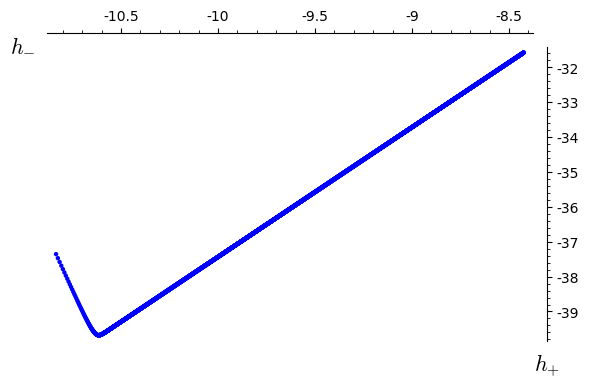

In [3]:
# T_i = 20, T_f = 25.4
(sep_traj,sep_hh_list)=separatrix(20,25.25)
list_plot(sep_hh_list,axes_labels=[r"$h_{-}$",r"$h_{+}$"])

Points are pruned from the trajectory when the ode runs away.  The value of $T_f$ is chosen by trial and error to capture the instability.

### try higher order 120 in the large $T$ expansion

In [4]:
N_tilde_coeffs =120
calc_fv_polys()

0  points pruned 5751  points


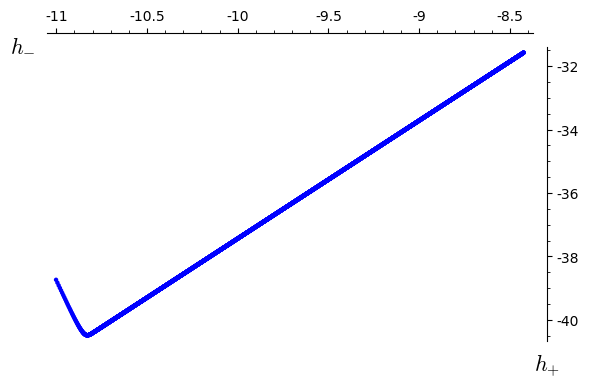

In [5]:
(sep_traj,sep_hh_list)=separatrix(20,25.75)
list_plot(sep_hh_list,axes_labels=[r"$h_{-}$",r"$h_{+}$"])

The instability shows up very slightly later in $T$, suggesting that the higher order expansion might be slightly more accurate at placing the initial point on the separatrix.

Now integrate backwards in $T$ to find the separatrix at large $h_{-}$.  Choose the earliest $T_f$ such that the solver does not run away (i.e., no points are pruned).

1  points pruned 20622  points


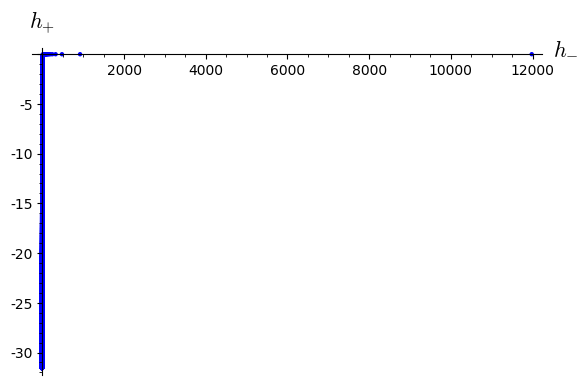

In [6]:
(sep_traj_back,sep_back_hh_list) = separatrix(20,-0.6220)
list_plot(sep_back_hh_list,axes_labels=[r"$h_{-}$",r"$h_{+}$"])

0  points pruned 20622  points


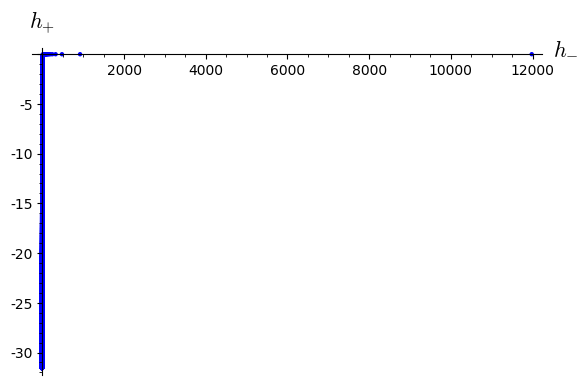

In [7]:
(sep_traj_back,sep_back_hh_list) = separatrix(20,-0.621)
list_plot(sep_back_hh_list,axes_labels=[r"$h_{-}$",r"$h_{+}$"])

Get the earliest point on the trajectory.

In [8]:
back_point = sep_traj_back[-1]; back_point

[-0.62099999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999998,
 11979.738443413583082144782481069482787725314129673935381110229234360188556339628695461441469072904293690294961463237222,
 -0.000083474276564673047602103434215648075436230636068420002091783368642468601744304745701367323280449836251819145030300315359]

Integrate foward from that earliest point until just before runaway.

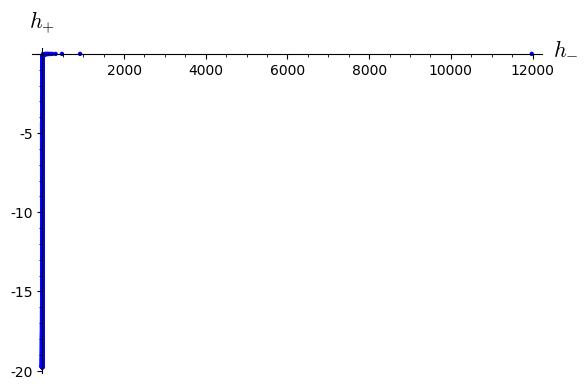

In [9]:
(sep_traj_forward,sep_forward_hh_list,number_pruned) =\
    calc_traj(back_point,12.82)
list_plot(sep_forward_hh_list,axes_labels=[r"$h_{-}$",r"$h_{+}$"])

Plot the points on the trajectory with $h_{-} < 10.0$, displaying the instability.

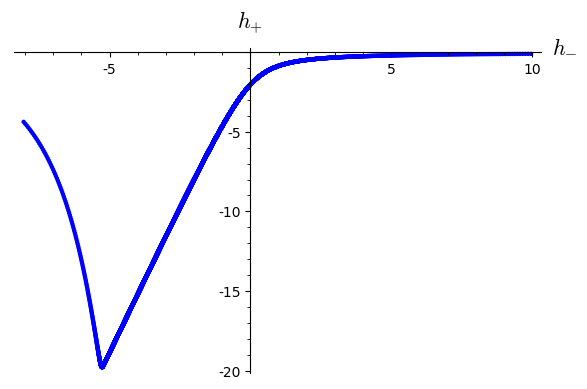

In [10]:
pruned=[point for point in sep_forward_hh_list if point[0]< 10.0]
list_plot(pruned,axes_labels=[r"$h_{-}$",r"$h_{+}$"])

Perturb the initial point very slightly to display the instability in both directions.

In [11]:
T_back = back_point[0]
hminus_back = back_point[1]
hplus_back = back_point[2]

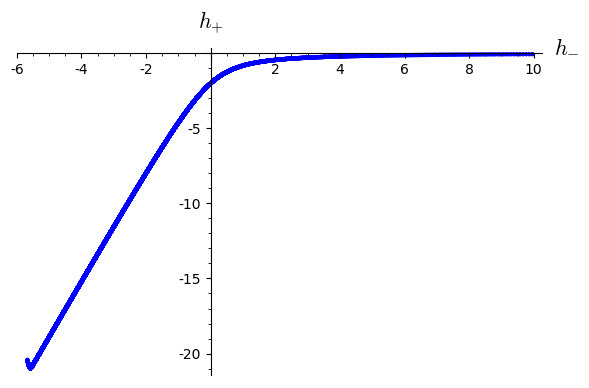

In [12]:
point_mod=[T_back,hminus_back,hplus_back - 1.31211060e-88 ]
(sep_traj_mod,sep_mod_hh_list,number_pruned) =\
    calc_traj(point_mod,13.4)
pruned=[point for point in sep_mod_hh_list if point[0]< 10.0]
list_plot(pruned,axes_labels=[r"$h_{-}$",r"$h_{+}$"])

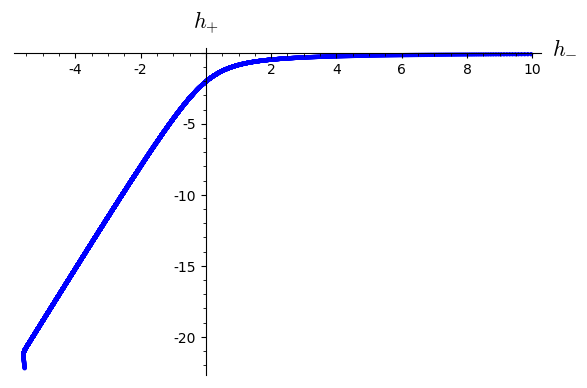

In [13]:
point_mod_2=[T_back,hminus_back,hplus_back - 1.31211061e-88]
(sep_traj_mod_2,sep_mod_2_hh_list,number_pruned_2) =\
    calc_traj(point_mod_2,13.4)
pruned=[point for point in sep_mod_2_hh_list if point[0]< 10.0]
list_plot(pruned,axes_labels=[r"$h_{-}$",r"$h_{+}$"])

The difference in the initial $h_{+}$ values is $O(10^{-96})$.  This is much smaller than the tolerance parameters of the ode solver.

Define a function to calculate the double expansion $e^S(x,y)$ to $O(x^N y^N)$
and a function to use $e^S(x,y)$ to calculate $c$.

In [14]:
Rxy.<xx,yy> = R[]
def calc_expS(N):
    j_size = N+1
    k_size = N+1
    zklist = [0.0 for k in range(k_size)]
    Sjk = [[0.0 for k in range(k_size)] for j in range(j_size)]
    Sjk[0][0] = 1.0
    if j_size > 1:
        Sjk[1][0] = 1.0
    for k in range(1,k_size):
        for j in range(1,j_size):
            Sjk[j][k] = ((2-j-(1+nu)*k)*Sjk[j-1][k] \
                         + (lambdaminus*j+(1-nu)*(k-1))*Sjk[j][k-1]) \
                        /(j+(2+nu)*k)
    expS = 0.0
    for j in range(j_size):
        for k in range(k_size):
            expS+= Sjk[j][k]*xx^j*yy^k
    return(expS)
def calc_c(point,expS):
    hminus_val = point[0]
    hplus_val = point[1]
    x_val = 1.0/hminus_val^2
    y_val = (hplus_val*hminus_val+1.0)*x_val
    expS_val = expS(xx=x_val,yy=y_val)
    c_val = expS_val*y_val*(x_val^(-2.0-nu))
    return(c_val)

For one of the two trajectories bracketing the separatrix, calculate $c$ at the earliest point for several values of $N$.

In [15]:
cvals={}
for N in range(10):
    expS = calc_expS(N)
    cvals[N] = calc_c(point_mod[1:],expS)

In [16]:
cvals

{0: 0.28445788665466583381471805147876193750348369531743315490387388017381802005436613900703825930517289597954613816749432817,
 1: 0.28445788863675554418877978914259637544544616653289475791447457114119762673701745040770625196759798492977030445020689204,
 2: 0.28445788863675554418877978914259637544053557077520960232297491369849384079444308496582665196457907472588138752667272458,
 3: 0.28445788863675554418877978914259637544053557079029671698615895337795517756130003494036406043263051121782074883638954280,
 4: 0.28445788863675554418877978914259637544053557079029671693057357826578273290504777101635027895311635213621996382967154836,
 5: 0.28445788863675554418877978914259637544053557079029671693057357849535473125067261485784686777059223949814030804694403173,
 6: 0.28445788863675554418877978914259637544053557079029671693057357849535473022464798120993511983711278571617736358154813162,
 7: 0.284457888636755544188779789142596375440535570790296716930573578495354730224647986069262415408114830365626

Check that the expansion improves with $N$ for small $N$.

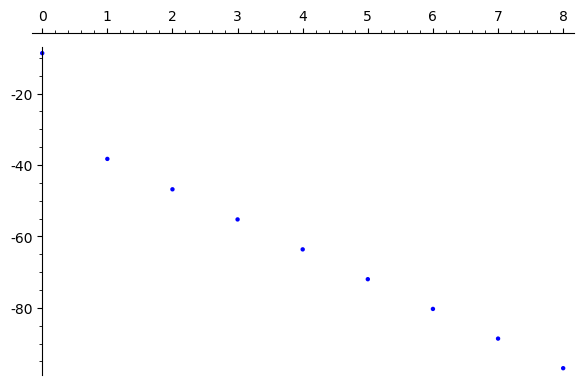

In [17]:
NN=0
logdevs = [[N,log(abs(cvals[N]-cvals[9]),10)] for N in cvals if N >=NN and N < 9]
list_plot(logdevs)

Evaluate the deviation in $c$ along the early part of the separatrix, i.e., small $T$, large $h_{-}$ to check the accuracy of the expansion of $e^s(x,y)$.

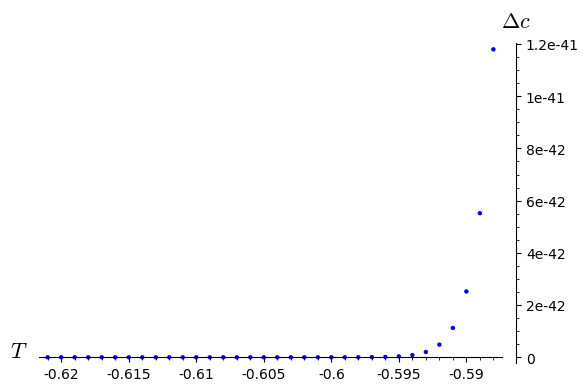

In [18]:
hminus_min = 30
expS = calc_expS(9)
Tc_list=[[point[0],calc_c(point[1:],expS)-cvals[9]] 
         for point in sep_traj_mod if point[1]>hminus_min]
list_plot(Tc_list,axes_labels=[r"$T$",r"$\Delta c$"])

### check numerical precision

In [19]:
nu*(1+nu)-0.5

0.00000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000

In [20]:
lambdaplus*lambdaminus-1

1.5490367659397273091272122533145407390280876768195163461951051765377665392390743859450728937108058387632230170030217870e-120

### check large T expansion of separatrix

In [21]:
N_tilde_coeffs = 10
calc_fv_polys()
test_ode = y*(0.5*y^2*f_poly.derivative(y)-f_poly*v_poly-f_poly^2-1)+f_poly
test_ode

5.9109714707410239459590521448978416357858977397635351659452142136058193323590324881683916140189492021067141957989139353e10*y^39 - 1.2371689146222568392662362600849397377664170507382153409043180489598123902677680903280798725102520982241349403752203940e10*y^37 + 2.0918528906674824373038519446503936596269825857957406873269514622352053620857438680864347427268892151141347116033286798e9*y^35 - 3.4192511731384801012290318940091859706049161508458237596236575505396044057852560930905279090897117784985942695370246068e8*y^33 + 5.7801148446586037557755313033172040022643511902463346288739693965031963479205623926760244535217772375883483574423198136e7*y^31 - 1.0582397791770538048771035564399633674067094158777555783081640148113461085373497061819114286825017841070985975671496604e7*y^29 + 2.2082062131082423016774882521181040588803694045790884526378724057795686447147031380724858115814498367519576002969360312e6*y^27 - 570053.894069787278181747080417659760508010919286540646195619295970547582303395739881445

### check accuracy of large T expansion

0  points pruned 1001  points


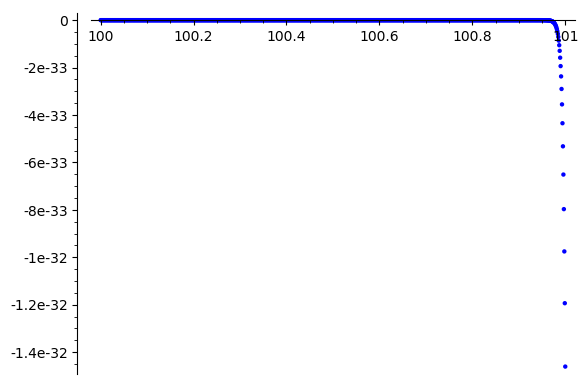

In [22]:
N_tilde_coeffs =100
calc_fv_polys()
[sep_traj_list_1,sep_hh_list_1] = separatrix(100,101)
#list_plot(sep_hh_list_1)
diff_list = [[point[0],point[1]-s_point(point[0])[1]] for point in sep_traj_list_1]
list_plot(diff_list)

### Try the large $T$ expansion for larger $T_i$

0  points pruned 4251  points


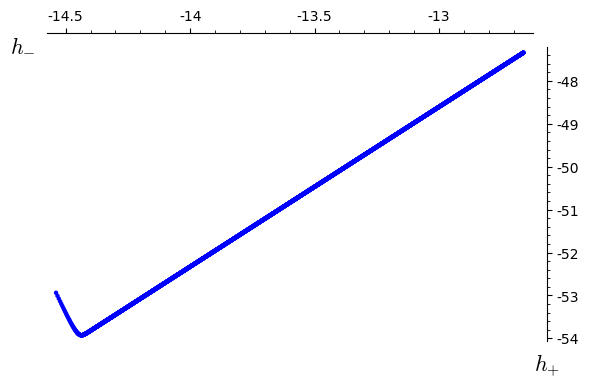

In [23]:
(sep_traj,sep_hh_list)=separatrix(30,34.25)
list_plot(sep_hh_list,axes_labels=[r"$h_{-}$",r"$h_{+}$"])

0  points pruned 2651  points


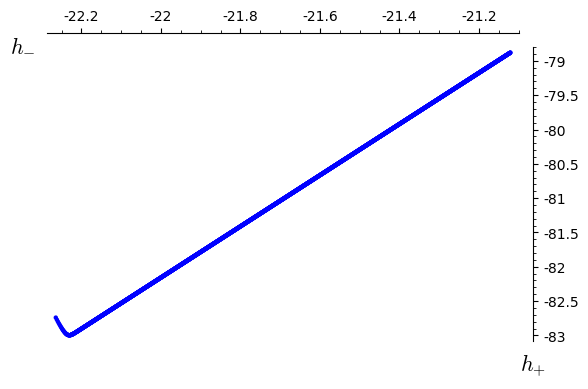

In [24]:
(sep_traj,sep_hh_list)=separatrix(50,52.65)
list_plot(sep_hh_list,axes_labels=[r"$h_{-}$",r"$h_{+}$"])